In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk_stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iromaykin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
ds = load_dataset("dair-ai/emotion", "split")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
df_train = ds['train'].to_pandas()
display(df_train)
df_test = ds['test'].to_pandas()
display(df_test)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0
...,...,...
1995,i just keep feeling like someone is being unki...,3
1996,im feeling a little cranky negative after this...,3
1997,i feel that i am useful to my people and that ...,1
1998,im feeling more comfortable with derby i feel ...,1


In [ ]:
# Инициализируем TF-IDF
vectorizer = TfidfVectorizer(stop_words=nltk_stop_words)

# Применяем векторизатор
tfidf_matrix = vectorizer.fit_transform(df_train['text'])
tfidf_matrix

<16000x15046 sparse matrix of type '<class 'numpy.float64'>'
	with 144778 stored elements in Compressed Sparse Row format>

In [ ]:
# Получаем имена признаков (слова)
feature_names = np.array(vectorizer.get_feature_names_out())
feature_names

array(['aa', 'aaaaaaand', 'aaaaand', ..., 'zum', 'zumba', 'zz'],
      dtype=object)

In [ ]:
# Создаём пустой DataFrame, куда будем сохранять результат
df_keywords = pd.DataFrame(columns=['Label', 'Keywords'])

# Группируем данные по классу и анализируем ключевые слова
for label, group in df_train.groupby('label'):

    # Суммируем значения TF-IDF по каждому слову для текущего класса
    tfidf_sum = np.sum(tfidf_matrix[group.index], axis=0)

    # Преобразуем полученные суммы в одномерный массив из (1, N) -> (N). Нужно просто для упрощения
    tfidf_sum = np.ravel(tfidf_sum)

    # Получаем индексы для сортировки слов по убыванию TF-IDF
    sorted_indices = tfidf_sum.argsort()[::-1]

    # Выбираем топ N слова для ключевых слов класса
    keywords = feature_names[sorted_indices][:150]

    # Добавляем результат в DataFrame
    new_row = pd.DataFrame({'Label': [label], 'Keywords': [keywords]})
    df_keywords = pd.concat([df_keywords, new_row], ignore_index=True)

df_keywords

,Label,Keywords
0,0,"[feel, feeling, like, im, really, know, still,..."
1,1,"[feel, feeling, like, im, really, time, pretty..."
2,2,"[feel, feeling, like, im, loving, caring, pass..."
3,3,"[feel, feeling, im, like, angry, really, irrit..."
4,4,"[feel, feeling, im, like, little, bit, anxious..."
5,5,"[feel, feeling, amazed, overwhelmed, impressed..."


### У нас одинаковые слова в разных классах. Если встретится слово "feel", то непонятно к какому классу относить такой объект. Поэтому нам надо удалить неуникальные для класса слова

In [ ]:
# Объединяем все слова в один список
vocab = list()
for i in range(0, 6, 1):
    vocab += df_keywords['Keywords'].to_list()[i].tolist()

# считаем кол-во повторений слов
word_frequency = {word:vocab.count(word) for word in vocab}
word_frequency
# {'feel': 6,
#  'feeling': 6,
#  'like': 6,
#  'im': 6,
#  'really': 6,
#  'know': 6,
#  ...


# Фильтруем
unique_words = {word: count for word, count in word_frequency.items() if count == 1}
unique_words
# {'sorry': 1,
#  'miserable': 1,
#  'stupid': 1,
#  'exhausted': 1,
#  'discouraged': 1,
#  ...

# Создаем новый DataFrame, где удаляем неуникальные слова из каждого списка
df_keywords['Filtered_Keywords'] = df_keywords['Keywords'].apply(lambda words: [word for word in words if word in unique_words])
df_keywords

,Label,Keywords,Filtered_Keywords
0,0,"[feel, feeling, like, im, really, know, still,...","[sorry, miserable, stupid, exhausted, discoura..."
1,1,"[feel, feeling, like, im, really, time, pretty...","[thankful, excited, glad, safe, content, impor..."
2,2,"[feel, feeling, like, im, loving, caring, pass...","[loving, caring, nostalgic, sympathetic, longi..."
3,3,"[feel, feeling, im, like, angry, really, irrit...","[angry, irritable, fucked, greedy, cold, irrit..."
4,4,"[feel, feeling, im, like, little, bit, anxious...","[anxious, nervous, terrified, scared, vulnerab..."
5,5,"[feel, feeling, amazed, overwhelmed, impressed...","[amazed, impressed, curious, surprised, shocke..."


### Теперь мы берем предложение из тестового датасета, если в нём есть ключевые слова какого-то класса, то это тот самый класс и мы присваем его предложению

In [ ]:
def determine_class(tokens):
    '''Функция для определения класса на основе токенов'''
    for label, keywords in zip(df_keywords['Label'], df_keywords['Filtered_Keywords']):
        cross = set(tokens) & set(keywords)
        if cross:
            return label
    return None  # Возвращаем None или другое значение, если не найдено совпадений

# применим функцию (предварительно разбив предложение на токены)
df_test['predicted_label'] = df_test['text'].apply(lambda text: determine_class(text.split(' ')))
df_test

,text,label,predicted_label
0,im feeling rather rotten so im not very ambiti...,0,0.0
1,im updating my blog because i feel shitty,0,0.0
2,i never make her separate from me because i do...,0,0.0
3,i left with my bouquet of red and yellow tulip...,1,1.0
4,i was feeling a little vain when i did this one,0,0.0
...,...,...,...
1995,i just keep feeling like someone is being unki...,3,5.0
1996,im feeling a little cranky negative after this...,3,3.0
1997,i feel that i am useful to my people and that ...,1,1.0
1998,im feeling more comfortable with derby i feel ...,1,1.0


### Проверим Nan, увидим что они есть. После чего проверим распределение классов у предсказанных меток test и у всех меток train

In [ ]:
df_test.isna().sum()

text                 0
label                0
predicted_label    325
dtype: int64

<Axes: >

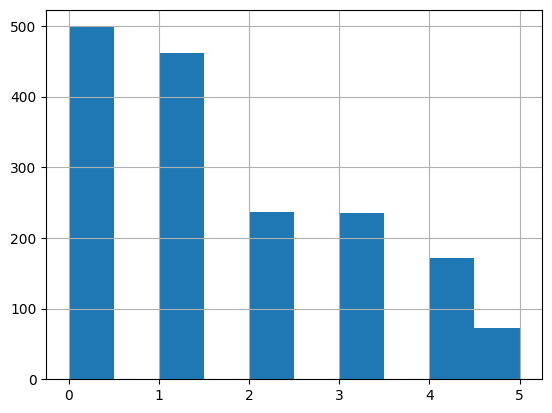

In [ ]:
df_test['predicted_label'].hist()

<Axes: >

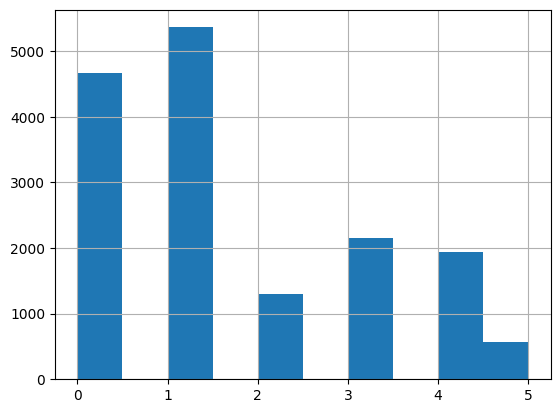

In [ ]:
df_train['label'].hist()

### Заметили, что по статистике 1ый класс немного недотягивает, а значит можем заменить NAN на 1-ый класс

In [ ]:
df_test['predicted__filled_label'] = df_test['predicted_label'].fillna(1)
df_test

,text,label,tokens,predicted_label,predicted__filled_label
0,im feeling rather rotten so im not very ambiti...,0,"[im, feeling, rather, rotten, so, im, not, ver...",0.0,0.0
1,im updating my blog because i feel shitty,0,"[im, updating, my, blog, because, i, feel, shi...",0.0,0.0
2,i never make her separate from me because i do...,0,"[i, never, make, her, separate, from, me, beca...",0.0,0.0
3,i left with my bouquet of red and yellow tulip...,1,"[i, left, with, my, bouquet, of, red, and, yel...",1.0,1.0
4,i was feeling a little vain when i did this one,0,"[i, was, feeling, a, little, vain, when, i, di...",0.0,0.0
...,...,...,...,...,...
1995,i just keep feeling like someone is being unki...,3,"[i, just, keep, feeling, like, someone, is, be...",5.0,5.0
1996,im feeling a little cranky negative after this...,3,"[im, feeling, a, little, cranky, negative, aft...",3.0,3.0
1997,i feel that i am useful to my people and that ...,1,"[i, feel, that, i, am, useful, to, my, people,...",1.0,1.0
1998,im feeling more comfortable with derby i feel ...,1,"[im, feeling, more, comfortable, with, derby, ...",1.0,1.0


### Посчитаем метрику, поймём что наш бейзлайн круче чем модельки, которые мы чекали на прошлой лекции

In [ ]:
from sklearn.metrics import f1_score
f1_score(df_test['label'], df_test['predicted__filled_label'], average='macro')

0.6788425464167133

# Эмбединги и релевантность VS Классификация

In [ ]:
import torch
from transformers import AutoModel
import pandas as pd
pd.set_option('display.max_colwidth', 90)

In [ ]:
# Загружаем модель
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModel.from_pretrained('jinaai/jina-clip-v1', trust_remote_code=True).to(device)

/opt/conda/envs/interns_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from datasets import load_dataset
ds = load_dataset('dair-ai/emotion', 'split')
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
df_test = ds['test'].to_pandas().sample(10)
display(df_test)

,text,label
1105,im now on day two of the plan and im feeling positive,1
1488,i managed however to relax and enjoy the scenery feeling romantic and thoroughly enjoy...,2
1722,i am feeling so appreciative today,1
1256,i feel more shy in swedish,4
573,i feel so bad about it and hes stood there bewildered,0
1220,i feel thrilled that by the end of the month this round will be completed and i can be...,1
1438,id ever known so i figured it was normal for me to feel ugly dumb and weird,0
1672,i was feeling brave i would try to pick up running again,1
1901,i did about nothing today and feel a little regretful,0
1138,i hate myself to feel so bothered by the word team the word badminton,3


In [ ]:
df_test['embds'] = df_test['text'].apply(lambda text: model.encode_text(text))
df_test

,text,label,embds
1105,im now on day two of the plan and im feeling positive,1,"[-0.033095907, 0.053195946, 0.0106947245, 0.057063755, -0.010350361, -0.060071997, -0...."
1488,i managed however to relax and enjoy the scenery feeling romantic and thoroughly enjoy...,2,"[-0.029360043, -0.03699516, 0.06503086, 0.050298735, -0.049312767, -0.07907277, -0.035..."
1722,i am feeling so appreciative today,1,"[-0.0055796034, 0.038444977, 0.0050711525, 0.024697855, -0.030574467, -0.040637366, -0..."
1256,i feel more shy in swedish,4,"[0.00020563224, -0.010120195, -0.033753973, 0.06072647, -0.017345283, -0.0067955954, -..."
573,i feel so bad about it and hes stood there bewildered,0,"[-0.09674959, -0.04443752, 0.023301747, 0.06516944, -3.066325e-05, 0.017661436, 0.0191..."
1220,i feel thrilled that by the end of the month this round will be completed and i can be...,1,"[-0.037740175, 0.051026188, 0.034130577, 0.033101127, -0.024070451, -0.026353892, 0.00..."
1438,id ever known so i figured it was normal for me to feel ugly dumb and weird,0,"[-0.023160757, -0.04969727, 0.0063968035, 0.02158688, 0.0181594, -5.0275867e-05, 0.019..."
1672,i was feeling brave i would try to pick up running again,1,"[0.019987553, 0.024820032, -0.0118655525, 0.014853533, 0.006453301, 0.045890316, -0.02..."
1901,i did about nothing today and feel a little regretful,0,"[0.020099288, 0.0034943298, -0.0012879625, 0.009738214, 0.0010075219, -0.024034908, 0...."
1138,i hate myself to feel so bothered by the word team the word badminton,3,"[-0.04450436, 0.0100865355, -0.035437018, 0.050182357, -0.010401474, 0.01887456, 0.015..."


In [ ]:
embds_emotions = model.encode_text([
    "Feeling of sadness",
    "Feeling of joy",
    "Feeling of love",
    "Feeling of anger",
    "Feeling of fear",
    "Feeling of surprise",
])
embds_emotions

array([[-0.04804822,  0.02059573,  0.03418766, ..., -0.00389277,
        -0.03349667,  0.0424952 ],
       [-0.03490588,  0.05484391,  0.02773596, ...,  0.00220047,
         0.03670068,  0.04538273],
       [-0.01971182,  0.02446335,  0.02098034, ...,  0.00211054,
         0.02534032,  0.02092118],
       [-0.03210814,  0.02978619, -0.01354042, ...,  0.03202091,
        -0.01123858,  0.06896573],
       [-0.03106002,  0.03226698, -0.03669915, ...,  0.04035518,
         0.02146339, -0.00578181],
       [-0.04248204,  0.03763591, -0.00321695, ..., -0.00594911,
        -0.02016057,  0.00817781]], dtype=float32)

In [ ]:
df_test['embds'].iloc[0]

array([-3.30959074e-02,  5.31959459e-02,  1.06947245e-02,  5.70637546e-02,
       -1.03503605e-02, -6.00719973e-02, -1.81617551e-02, -1.15894722e-02,
        7.54879937e-02, -5.17492071e-02, -3.15934569e-02,  1.81461126e-02,
       -2.37603188e-02,  1.17924381e-02, -1.30970823e-02,  5.48881814e-02,
        2.20812950e-02,  8.23446140e-02,  1.11002326e-02,  7.80624477e-03,
       -4.92395200e-02,  3.14557962e-02, -9.44635347e-02, -7.43647572e-03,
       -3.93421063e-03,  1.76184755e-02,  1.65484380e-02,  4.24963459e-02,
       -3.69546609e-03,  1.00454933e-03,  1.12818014e-02, -4.56684232e-02,
        2.73517855e-02,  2.22309623e-02,  3.18903588e-02, -1.69305354e-02,
       -3.67214680e-02, -2.44681872e-02, -1.49952825e-02, -2.43339799e-02,
       -3.09722889e-02,  1.08609488e-02, -4.27845307e-03, -8.89809243e-03,
        2.52966639e-02, -7.74580380e-03, -4.89967093e-02,  3.38577665e-02,
        1.99631322e-02,  1.18154120e-02,  3.92591804e-02,  7.24430755e-02,
       -7.02024698e-02, -

In [ ]:
embds_emotions @ df_test['embds'].iloc[0]

array([0.21790613, 0.3597594 , 0.21479884, 0.16745107, 0.16718003,
       0.26487005], dtype=float32)

In [ ]:
def get_similarity(embds):
    similarities = embds_emotions @ embds

    return pd.Series(similarities)

df_test[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']] = df_test['embds'].apply(get_similarity)
df_test

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
0,im feeling rather rotten so im not very ambitious right now,0,"[-0.020548554, -0.009849964, -0.0140467435, 0.035732057, -0.021579504, 0.020982355, -0...",0.323309,0.172329,0.066639,0.324759,0.229126,0.150058,3
1,im updating my blog because i feel shitty,0,"[-0.026600258, -0.041243114, 0.01294523, 0.01436325, 0.0012461455, -0.010736853, 0.038...",0.295851,0.195870,0.107491,0.188194,0.149156,0.123259,0
2,i never make her separate from me because i don t ever want her to feel like i m asham...,0,"[-0.0315496, 0.003717405, 0.022025127, 0.06043242, -0.03345932, 0.02627146, 0.01174086...",0.204744,0.033691,0.101969,0.153173,0.137117,0.061680,0
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more opt...,1,"[0.014529553, 0.010851229, -0.010844922, -0.011989393, -0.06278262, -0.00090474985, -0...",0.385867,0.398996,0.296326,0.315984,0.267769,0.417424,1
4,i was feeling a little vain when i did this one,0,"[-0.041803338, -0.034731757, 0.03269688, 0.029229572, -0.022091327, -0.012157314, 0.08...",0.345960,0.310278,0.264783,0.293176,0.295439,0.329212,0
...,...,...,...,...,...,...,...,...,...,...
1995,i just keep feeling like someone is being unkind to me and doing me wrong and then all...,3,"[0.020784894, -0.009004512, 0.008729557, 0.043190878, 0.03545178, 0.03699454, 0.000159...",0.282148,0.195044,0.254165,0.350452,0.303652,0.239240,3
1996,im feeling a little cranky negative after this doctors appointment,3,"[-0.03505036, 0.036020603, 0.06047656, -0.026088238, -0.018854648, -0.00961301, -0.012...",0.370364,0.255612,0.111984,0.309126,0.290787,0.247292,0
1997,i feel that i am useful to my people and that gives me a great feeling of achievement,1,"[0.0025604519, 0.04090742, -0.0045322683, 0.02633886, -0.006051212, -0.018447466, -0.0...",0.221545,0.410143,0.336175,0.180509,0.212914,0.347823,1
1998,im feeling more comfortable with derby i feel as though i can start to step out my shell,1,"[-0.02871013, 0.0034782067, 0.040505774, -0.020887595, -0.037975896, 0.020023327, -0.0...",0.221169,0.237076,0.182744,0.133267,0.267062,0.206799,4


### Теперь это надо как-то преобразовать в классы

In [ ]:
# Для этого просто для каждого объекта возьмем название колонки, в которой у него максимальный score
emotion_columns = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
df_test['predicted_class'] = df_test[emotion_columns].idxmax(axis=1)
df_test

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
0,im feeling rather rotten so im not very ambitious right now,0,"[-0.020548554, -0.009849964, -0.0140467435, 0.035732057, -0.021579504, 0.020982355, -0...",0.323309,0.172329,0.066639,0.324759,0.229126,0.150058,anger
1,im updating my blog because i feel shitty,0,"[-0.026600258, -0.041243114, 0.01294523, 0.01436325, 0.0012461455, -0.010736853, 0.038...",0.295851,0.195870,0.107491,0.188194,0.149156,0.123259,sadness
2,i never make her separate from me because i don t ever want her to feel like i m asham...,0,"[-0.0315496, 0.003717405, 0.022025127, 0.06043242, -0.03345932, 0.02627146, 0.01174086...",0.204744,0.033691,0.101969,0.153173,0.137117,0.061680,sadness
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more opt...,1,"[0.014529553, 0.010851229, -0.010844922, -0.011989393, -0.06278262, -0.00090474985, -0...",0.385867,0.398996,0.296326,0.315984,0.267769,0.417424,surprise
4,i was feeling a little vain when i did this one,0,"[-0.041803338, -0.034731757, 0.03269688, 0.029229572, -0.022091327, -0.012157314, 0.08...",0.345960,0.310278,0.264783,0.293176,0.295439,0.329212,sadness
...,...,...,...,...,...,...,...,...,...,...
1995,i just keep feeling like someone is being unkind to me and doing me wrong and then all...,3,"[0.020784894, -0.009004512, 0.008729557, 0.043190878, 0.03545178, 0.03699454, 0.000159...",0.282148,0.195044,0.254165,0.350452,0.303652,0.239240,anger
1996,im feeling a little cranky negative after this doctors appointment,3,"[-0.03505036, 0.036020603, 0.06047656, -0.026088238, -0.018854648, -0.00961301, -0.012...",0.370364,0.255612,0.111984,0.309126,0.290787,0.247292,sadness
1997,i feel that i am useful to my people and that gives me a great feeling of achievement,1,"[0.0025604519, 0.04090742, -0.0045322683, 0.02633886, -0.006051212, -0.018447466, -0.0...",0.221545,0.410143,0.336175,0.180509,0.212914,0.347823,joy
1998,im feeling more comfortable with derby i feel as though i can start to step out my shell,1,"[-0.02871013, 0.0034782067, 0.040505774, -0.020887595, -0.037975896, 0.020023327, -0.0...",0.221169,0.237076,0.182744,0.133267,0.267062,0.206799,fear


In [ ]:
# Преобразуем в циферки
emotion_to_class = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
df_test['predicted_class'] = df_test['predicted_class'].map(emotion_to_class)
df_test

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
0,im feeling rather rotten so im not very ambitious right now,0,"[-0.020548554, -0.009849964, -0.0140467435, 0.035732057, -0.021579504, 0.020982355, -0...",0.323309,0.172329,0.066639,0.324759,0.229126,0.150058,3
1,im updating my blog because i feel shitty,0,"[-0.026600258, -0.041243114, 0.01294523, 0.01436325, 0.0012461455, -0.010736853, 0.038...",0.295851,0.195870,0.107491,0.188194,0.149156,0.123259,0
2,i never make her separate from me because i don t ever want her to feel like i m asham...,0,"[-0.0315496, 0.003717405, 0.022025127, 0.06043242, -0.03345932, 0.02627146, 0.01174086...",0.204744,0.033691,0.101969,0.153173,0.137117,0.061680,0
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more opt...,1,"[0.014529553, 0.010851229, -0.010844922, -0.011989393, -0.06278262, -0.00090474985, -0...",0.385867,0.398996,0.296326,0.315984,0.267769,0.417424,5
4,i was feeling a little vain when i did this one,0,"[-0.041803338, -0.034731757, 0.03269688, 0.029229572, -0.022091327, -0.012157314, 0.08...",0.345960,0.310278,0.264783,0.293176,0.295439,0.329212,0
...,...,...,...,...,...,...,...,...,...,...
1995,i just keep feeling like someone is being unkind to me and doing me wrong and then all...,3,"[0.020784894, -0.009004512, 0.008729557, 0.043190878, 0.03545178, 0.03699454, 0.000159...",0.282148,0.195044,0.254165,0.350452,0.303652,0.239240,3
1996,im feeling a little cranky negative after this doctors appointment,3,"[-0.03505036, 0.036020603, 0.06047656, -0.026088238, -0.018854648, -0.00961301, -0.012...",0.370364,0.255612,0.111984,0.309126,0.290787,0.247292,0
1997,i feel that i am useful to my people and that gives me a great feeling of achievement,1,"[0.0025604519, 0.04090742, -0.0045322683, 0.02633886, -0.006051212, -0.018447466, -0.0...",0.221545,0.410143,0.336175,0.180509,0.212914,0.347823,1
1998,im feeling more comfortable with derby i feel as though i can start to step out my shell,1,"[-0.02871013, 0.0034782067, 0.040505774, -0.020887595, -0.037975896, 0.020023327, -0.0...",0.221169,0.237076,0.182744,0.133267,0.267062,0.206799,4


In [ ]:
from sklearn.metrics import f1_score
f1_score(df_test['label'], df_test['predicted_class'], average='macro')

0.4136667578962308

## Классификация оказалась лучше
## А теперь представим ситуацию, что нам просто нужно найти топ-5 самых грустных\весёлых\\... эмоций

In [ ]:
df_test.sort_values(by='sadness', ascending=False).head()

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
482,i was feeling whether it be mad sad disappointed or peaceful,3,"[-0.08201992, -0.01992977, 0.01585222, 0.06345329, -0.038526494, -0.0071162204, -0.007...",0.668932,0.434103,0.353796,0.526769,0.442419,0.429424,0
32,i start to feel emotional,0,"[-0.051199388, 0.02091717, 0.019683674, 0.09192027, 0.0022191717, 0.039049968, -0.0301...",0.652552,0.530715,0.503851,0.569179,0.514830,0.480536,0
784,i feel pained by this,0,"[-0.04055836, 0.026028834, 0.034400564, 0.04139765, -0.04908285, 0.022642149, 0.057049...",0.650800,0.419429,0.363408,0.516733,0.486219,0.422240,0
334,ive been feeling a bit melancholy,0,"[-0.051132604, -0.0287409, 0.036008656, 0.07249024, -0.050917804, 0.006614047, -0.0283...",0.648322,0.399771,0.364804,0.424463,0.360334,0.322318,0
361,im still feeling very emotional,0,"[-0.016142922, -0.032015372, 0.015345683, 0.039772287, -0.03364119, 0.045030717, -0.04...",0.643821,0.435217,0.442132,0.503155,0.385830,0.349140,0


In [ ]:
df_test.sort_values(by='joy', ascending=False).head()

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
1410,i am feeling joyful every part of me feels happy and light and whimsical,1,"[-0.011160251, 0.014779679, 0.01479612, 0.008616015, -0.03655404, 0.005469987, -0.0623...",0.440895,0.744054,0.570394,0.359803,0.342561,0.458336,1
1231,i feel special excitement and happiness,1,"[-0.03054253, 0.042271607, 0.019314738, 0.033501215, -0.021910192, 0.0034468295, -0.04...",0.514701,0.730570,0.612805,0.382777,0.441220,0.686882,1
87,i am feeling so happy,1,"[-0.04601167, 0.028528214, 0.022582775, 0.030809471, -0.021002125, -0.01968225, -0.036...",0.451066,0.668355,0.531002,0.359912,0.318068,0.516116,1
672,i take a walk in the park feeling joyful,1,"[-0.03170148, 0.04783493, 0.0463571, 0.03936349, -0.025246164, -0.02030468, -0.0046706...",0.343684,0.641036,0.416395,0.315518,0.292005,0.350699,1
1005,i felt joyful then it subsided now i feel joyful again,1,"[-0.011433969, 0.00573455, -0.0038930776, 0.01005558, -0.037332986, 0.0052154087, -0.0...",0.447719,0.632826,0.385984,0.352701,0.310167,0.425865,1


In [ ]:
df_test.sort_values(by='love', ascending=False).head()

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
294,i just want to know the feeling of loving and be loved,2,"[-0.035169892, 0.027752927, 0.06101503, 0.052427456, -0.016196428, -0.0039353846, -0.0...",0.407566,0.542034,0.724149,0.326714,0.379128,0.404456,2
957,i wonder how it feels to be loved by someone you love,2,"[-0.049180813, 0.041378018, 0.07314224, 0.05294099, 0.008632494, -0.003400992, 0.01598...",0.441766,0.446603,0.669155,0.297948,0.379778,0.424147,2
1017,i feel a lot of affection for you that is longing to be conveyed,2,"[-0.051414937, -0.0017546455, 0.02854532, 0.06925947, -0.05357801, -0.0052413745, -0.0...",0.451165,0.499992,0.667693,0.353352,0.369502,0.438260,2
1231,i feel special excitement and happiness,1,"[-0.03054253, 0.042271607, 0.019314738, 0.033501215, -0.021910192, 0.0034468295, -0.04...",0.514701,0.730570,0.612805,0.382777,0.441220,0.686882,1
1333,i just want to feel loved by you,2,"[-0.020354101, 0.0034787313, 0.06577213, 0.04205573, -0.04622116, -0.0071421186, -0.03...",0.372773,0.465980,0.601967,0.266690,0.301190,0.340662,2


In [ ]:
df_test.sort_values(by='anger', ascending=False).head()

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
1435,i feel anger i feel sad i feel joy and i feel other emotions too but will stick to a few,0,"[-0.055521876, 0.040590193, 0.008081801, 0.024528215, 0.006674703, 0.022564013, -0.009...",0.616231,0.567052,0.498924,0.653971,0.463038,0.392573,3
610,i feel pissed off and angry,3,"[-0.032217927, -0.033454675, -0.00620753, 0.03335558, -0.00274755, 0.04460561, 0.02811...",0.564426,0.355409,0.244536,0.649608,0.434841,0.344856,3
308,i know what you mean about feeling agitated,4,"[-0.042712655, -0.024412477, -0.021236883, 0.05420806, -0.022032112, 0.05429223, 0.008...",0.511696,0.364500,0.272258,0.639755,0.449080,0.344855,3
1986,im feeling scared and the rage filled im mad at me,4,"[-0.059524063, -0.026272265, -0.05607233, 0.02778637, -0.011336666, 0.071243, 0.008843...",0.467272,0.291332,0.205897,0.599532,0.523139,0.290250,3
537,i feel so damn agitated,3,"[-0.055990297, -0.03098575, 0.010990707, 0.05782147, -0.017353192, 0.03151283, 0.00017...",0.567592,0.349905,0.251425,0.598594,0.412822,0.357215,3


In [ ]:
df_test.sort_values(by='fear', ascending=False).head()

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
1975,i feel scared anxious,4,"[-0.021801969, 0.016234573, -0.029473905, 0.036257893, 0.0036088172, 0.04137376, 0.020...",0.495265,0.340718,0.295287,0.483416,0.712732,0.441471,4
1321,i know what it feels like to be scared into something,4,"[-0.03304429, 0.02769061, -0.015195066, 0.021274868, 0.0057049952, 0.040156577, 0.0131...",0.423298,0.369700,0.385066,0.400640,0.710011,0.496898,4
626,i remember feeling so frightened that i could feel emotions at that high a level,4,"[-0.017955653, 0.032651406, 0.0040553855, 0.0060199914, 0.04514064, -0.0093001425, -0....",0.492135,0.379698,0.370843,0.459577,0.637023,0.448452,4
25,i hate it when i feel fearful for absolutely no reason,4,"[-0.041513983, 0.023811337, -0.0046065175, 0.031936876, 0.019913862, 0.0070986054, 0.0...",0.413522,0.211660,0.234881,0.386926,0.618387,0.214831,4
786,i am feeling pretty fearless,1,"[-0.006612243, 0.0014203297, -0.058546726, 0.05744741, 0.0071800854, 0.021445777, -0.0...",0.394691,0.380704,0.380517,0.343743,0.609835,0.411482,4


In [ ]:
df_test.sort_values(by='surprise', ascending=False).head()

,text,label,embds,sadness,joy,love,anger,fear,surprise,predicted_class
1231,i feel special excitement and happiness,1,"[-0.03054253, 0.042271607, 0.019314738, 0.033501215, -0.021910192, 0.0034468295, -0.04...",0.514701,0.730570,0.612805,0.382777,0.441220,0.686882,1
867,i was truly surprised and feel quite honored,1,"[-0.00062520296, 0.0049925805, 0.0033100783, -0.01035877, -0.034299046, 0.0070795277, ...",0.282503,0.462780,0.301762,0.191630,0.222005,0.657483,5
57,i have a good feeling about this so i am excited,1,"[-0.04375461, 0.02704485, 0.01386826, 0.014221624, 0.0028787965, -0.0124388095, 0.0267...",0.371477,0.566106,0.445495,0.332232,0.418682,0.604495,5
142,i am feeling apprehensive about it but also wildly excited,4,"[-0.07482116, 0.0029808308, -0.014879507, 0.006214101, 0.007021192, -0.006519559, -0.0...",0.453909,0.462747,0.389941,0.454241,0.505982,0.604134,5
1307,im gestating one and feeling pretty thrilled about that,1,"[-0.05856482, 0.031560857, -0.006978364, 0.0011988276, -0.028906656, -0.020548988, -0....",0.392273,0.545287,0.402238,0.319470,0.380956,0.581931,5
